## dataset seq_len 512

In [1]:
from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
from transformers import GPT2Model, GPT2Config, GPT2LMHeadModel
from transformers import DataCollatorForLanguageModeling

2022-12-02 15:36:42.253580: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [3]:
device = torch.device('cuda:3')

In [ ]:
!curl https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-103-raw-v1.zip -o wikitext-103-raw-v1.zip

!unzip wikitext-103-raw-v1.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  183M  100  183M    0     0  5331k      0  0:00:35  0:00:35 --:--:-- 7351k
Archive:  wikitext-103-raw-v1.zip
replace wikitext-103-raw/wiki.test.raw? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
import os
from tqdm import tqdm
def evaluate(model, dataset_valid, tokenizer, prefix=""):
    # Loop to handle MNLI double evaluation (matched, mis-matched)

    eval_dataset = dataset_valid
    eval_batch_size = 2
    eval_sampler = SequentialSampler(eval_dataset)

    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=eval_batch_size, collate_fn = data_collator, pin_memory=True, num_workers=4)

    # Eval!
    
    eval_loss = 0.0
    perplexity = 0.0
    nb_eval_steps = 0
    model.eval()
    losses = []
    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        inputs, labels = batch['input_ids'], batch['labels']#(batch, batch)
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs, labels=labels)
            lm_loss = outputs[0]
            eval_loss += lm_loss.mean().item()
            perplexity += torch.exp(torch.tensor(eval_loss))
            losses.append(eval_loss)
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    #perplexity = perplexity / nb_eval_steps
    perplexity = torch.exp(torch.tensor(eval_loss))


    result = {
        "perplexity": perplexity,
        "loss":eval_loss
    }
    return result

In [5]:
from transformers import TextDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

#dataset_train = TextDataset(tokenizer=tokenizer, 
                                #file_path="/notebook/greenAI/wikitext-103/wiki.train.tokens", 
                                #block_size=512)

dataset_test = TextDataset(tokenizer=tokenizer, 
                                file_path="/notebook/greenAI/low_scaling_test/wikitext-103-raw/wiki.test.raw", 
                                block_size=1024)


/opt/.pyenv/versions/3.8.10/lib/python3.8/site-packages/transformers/data/datasets/language_modeling.py:54: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/language-modeling/run_mlm.py
  warnings.warn(


In [6]:
from transformers import GPT2Model, GPT2Config, GPT2LMHeadModel
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2-medium")

In [9]:
print(sum(p.numel() for p in model.parameters()))

354823168


/tmp/ipykernel_427941/2850273472.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  print(sum(p.numel() for p in model.parameters()))


In [7]:
evaluate(model.to(torch.device('cuda:3')), dataset_test, tokenizer)

Evaluating: 100% 140/140 [00:17<00:00,  8.14it/s]


{'perplexity': tensor(20.9545), 'loss': 3.042354350430625}

In [13]:
def estimate(model_name):
    model = GPT2LMHeadModel.from_pretrained(model_name)
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    metric = evaluate(model.to(torch.device('cuda:3')), dataset_test, tokenizer)
    num_param = sum(p.numel() for p in model.parameters())
    return {"model_name": model_name, "num_param": num_param, "metric": metric}

In [14]:
scores = []
for model_name in ["gpt2", "gpt2-medium", "gpt2-large", "distilgpt2", "sberbank-ai/mGPT"]:
    a = estimate(model_name)
    scores.append(a)
    print (a)

Evaluating: 100% 140/140 [00:07<00:00, 18.62it/s]


{'model_name': 'gpt2', 'num_param': 124439808, 'metric': {'perplexity': tensor(29.0307), 'loss': 3.3683534894670757}}


Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Evaluating: 100% 140/140 [00:17<00:00,  8.18it/s]


{'model_name': 'gpt2-medium', 'num_param': 354823168, 'metric': {'perplexity': tensor(20.9545), 'loss': 3.042354350430625}}


Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Evaluating: 100% 140/140 [00:31<00:00,  4.41it/s]


{'model_name': 'gpt2-large', 'num_param': 774030080, 'metric': {'perplexity': tensor(18.0844), 'loss': 2.8950482300349645}}


Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/353M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Evaluating: 100% 140/140 [00:05<00:00, 25.97it/s]


{'model_name': 'distilgpt2', 'num_param': 81912576, 'metric': {'perplexity': tensor(43.4745), 'loss': 3.7721746597971233}}


Downloading:   0%|          | 0.00/725 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.45G [00:00<?, ?B/s]

KeyboardInterrupt: 

In [34]:
tokenizer = GPT2Tokenizer.from_pretrained("distilgpt2")
print('Load model')
external_model = GPT2LMHeadModel.from_pretrained("distilgpt2")

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Load model


In [35]:
num_param = sum(p.numel() for p in external_model.parameters())

In [36]:
num_param

81912576

In [37]:
metric = evaluate(external_model.to(torch.device('cuda:1')), dataset_test, tokenizer)

Evaluating: 100%|██████████| 280/280 [00:04<00:00, 64.39it/s]


In [38]:
metric

{'perplexity': tensor(51.1908), 'loss': 3.935559701919556}

In [ ]:
gpt-2 small	124439808	34.54
gpt-2 med	354823168	24.72
gpt-2 large	774030080	21.49
gpt-2 distill	81912576	51.19
mgpt	1417596928	14809.6318
opt 1.5 B	1315758080	19.53
opt 1350m	331196416	30.02
opt 2.7 B	2651596800	16.88

## Plots

Populating the interactive namespace from numpy and matplotlib


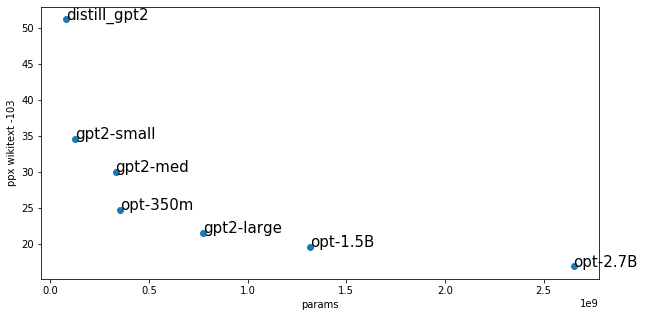

In [27]:
import matplotlib.pyplot as plt
%pylab inline
y = [51.19, 34.54, 30.02, 24.72, 21.49, 19.53, 16.88]
z = [81912576, 124439808, 331196416, 354823168, 774030080, 1315758080, 2651596800]
n = ['distill_gpt2', 'gpt2-small', 'gpt2-med', 'opt-350m','gpt2-large', 'opt-1.5B', 'opt-2.7B']
sizes = [15, 15, 15, 15, 15, 15, 15]


fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(z, y)

ax.set_ylabel('ppx wikitext -103')
ax.set_xlabel('params')

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]), fontsize=sizes[i])
    
fig.savefig('ax2_figure.png')

## dataset seq_len 1024

In [11]:
dataset_test = TextDataset(tokenizer=tokenizer, 
                                file_path="/notebook/greenAI/low_scaling_test/wikitext-103-raw/wiki.test.raw", 
                                block_size=1024)


In [16]:
scores = []
for model_name in ["gpt2", "gpt2-medium", "gpt2-large", "distilgpt2", "sberbank-ai/mGPT"]:
    a = estimate(model_name)
    scores.append(a)
    print (a)

Evaluating: 100%|██████████| 140/140 [00:06<00:00, 22.24it/s]


{'model_name': 'gpt2', 'num_param': 124439808, 'metric': {'perplexity': tensor(29.0309), 'loss': 3.3683608395712716}}


Evaluating: 100%|██████████| 140/140 [00:15<00:00,  8.85it/s]


{'model_name': 'gpt2-medium', 'num_param': 354823168, 'metric': {'perplexity': tensor(20.9546), 'loss': 3.0423574141093663}}


Evaluating: 100%|██████████| 140/140 [00:28<00:00,  4.95it/s]


{'model_name': 'gpt2-large', 'num_param': 774030080, 'metric': {'perplexity': tensor(18.0844), 'loss': 2.8950469153267995}}


Evaluating: 100%|██████████| 140/140 [00:03<00:00, 35.11it/s]


{'model_name': 'distilgpt2', 'num_param': 81912576, 'metric': {'perplexity': tensor(43.4745), 'loss': 3.772175123010363}}


Evaluating: 100%|██████████| 140/140 [00:37<00:00,  3.78it/s]

{'model_name': 'sberbank-ai/mGPT', 'num_param': 1417596928, 'metric': {'perplexity': tensor(24074.6777), 'loss': 10.088915429796492}}


Populating the interactive namespace from numpy and matplotlib


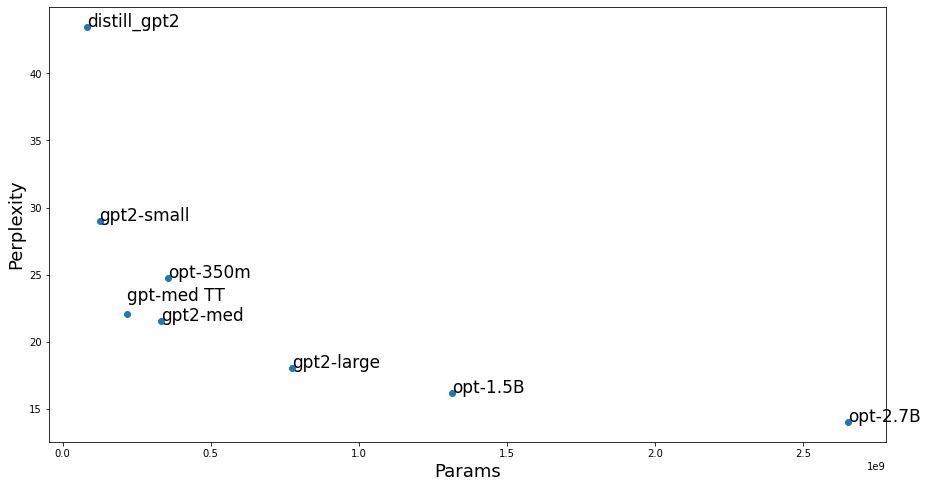

In [15]:
import matplotlib.pyplot as plt
%pylab inline
y = [43.47, 29.03, 21.56, 24.75, 18.08, 16.19, 14.02, 22.08]
z = [81912576, 124439808, 331196416, 354823168, 774030080, 1315758080, 2651596800, 218303488]
n = ['distill_gpt2', 'gpt2-small', 'gpt2-med', 'opt-350m','gpt2-large', 'opt-1.5B', 'opt-2.7B', 'gpt-med TT']
sizes = [17, 17, 17, 17, 17, 17, 17, 17]


fig, ax = plt.subplots(figsize=(15, 8))

ax.scatter(z, y)

ax.set_ylabel('Perplexity', fontsize=18)
ax.set_xlabel('Params',fontsize=18)

for i, txt in enumerate(n):
    if (i == 7):
        ax.annotate(txt, (z[i], y[i]), xytext = (z[i], y[i]+1), fontsize=sizes[i])
    else:
        ax.annotate(txt, (z[i], y[i]), fontsize=sizes[i])
    
fig.savefig('ax2_figure_1024.png')

## opt

In [20]:
import transformers

In [5]:
!pip3 install transformers --q

You should consider upgrading via the 'pip install --upgrade pip' command.


In [21]:
transformers.__version__

'4.20.1'

In [31]:
from transformers import OPTForCausalLM, GPT2Tokenizer

In [42]:
model_name_or_path = "facebook/opt-2.7b"

model = OPTForCausalLM.from_pretrained(model_name_or_path)
tokenizer = GPT2Tokenizer.from_pretrained(model_name_or_path)
model.gradient_checkpointing_enable() 



In [39]:
dataset_test = TextDataset(tokenizer=tokenizer, 
                                file_path="/notebook/greenAI/low_scaling_test/wikitext-103-raw/wiki.test.raw", 
                                block_size=1024)


In [43]:
model.eval()
metric = evaluate(model.to(torch.device('cuda:2')), dataset_test, tokenizer)
num_param = sum(p.numel() for p in model.parameters())
print(model_name, num_param, metric)

Evaluating: 100%|██████████| 140/140 [01:00<00:00,  2.32it/s]

sberbank-ai/mGPT 2651596800 {'perplexity': tensor(14.0182), 'loss': 2.640358360324587}



/opt/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  This is separate from the ipykernel package so we can avoid doing imports until


## regular

In [29]:
import sys
sys.path
sys.path.append('/notebook/greenAI/')
print(sys.path)

['/notebook/greenAI/all_small_chekpoints', '/notebook/greenAI/all_small_chekpoints', '/notebook', '/opt/.pyenv/versions/3.7.4/lib/python37.zip', '/opt/.pyenv/versions/3.7.4/lib/python3.7', '/opt/.pyenv/versions/3.7.4/lib/python3.7/lib-dynload', '', '/root/.local/lib/python3.7/site-packages', '/opt/.pyenv/versions/3.7.4/lib/python3.7/site-packages', '/notebook/transformers/src', '/notebook/torch', '/notebook/tensorly', '/opt/.pyenv/versions/3.7.4/lib/python3.7/site-packages/IPython/extensions', '/root/.ipython', '/notebook/greenAI/', '/notebook/greenAI/', '/notebook/greenAI/']


In [12]:
from help_trainer import evaluate

In [30]:
from transformers import GPT2Model, GPT2Config, GPT2LMHeadModel
from src.classes.gpt2_tt import GPT2_TT_Model
# Initializing a GPT2 configuration
configuration = GPT2Config()



In [31]:
# Initializing a model from the configuration
model = GPT2LMHeadModel(configuration)

# Accessing the model configuration
configuration = model.config

In [32]:
import torch
model.load_state_dict(torch.load('/notebook/greenAI/small_chekpoints/rank_0/checkpoint_best/model_tt.pth'))


<All keys matched successfully>

In [33]:
evaluate(args, model.to(torch.device('cuda:4')), dataset_test, tokenizer)

Evaluating: 100%|██████████| 279/279 [00:12<00:00, 21.82it/s]


{'perplexity': tensor(17.6614), 'loss': 2.871383121791279}

In [28]:
model.load_state_dict(torch.load('/notebook/greenAI/small_chekpoints/rank_16/checkpoint-116000/model_tt.pth'))
evaluate(args, model.to(torch.device('cuda:4')), dataset_test, tokenizer)

Evaluating: 100%|██████████| 279/279 [00:15<00:00, 18.03it/s]


{'perplexity': tensor(21.6283), 'loss': 3.0740016809928377}

## rank 128

In [ ]:
import torch
from src.classes.gpt2_tt import GPT2_TT_Model

model = GPT2_TT_Model(configuration, rank = 128)

In [26]:
model.load_state_dict(torch.load('/notebook/greenAI/small_chekpoints/rank128/checkpoint_best/model_tt.pth'))
evaluate(args, model.to(torch.device('cuda:4')), dataset_test, tokenizer)

Evaluating: 100%|██████████| 279/279 [00:14<00:00, 18.94it/s]


{'perplexity': tensor(18.0561), 'loss': 2.8934844305011107}